## Medical Insurance Cost Prediction Project

#### About Project
The problem that is being tackled in this project is the estimation of health insurance costs using individuals personal and health-related information. It can be useful for insurance companies to estimate the cost of insuring a person.

#### Brief introduction

In this project, my main aim is to find the optimal regression model which would predict a fee that the insurance company will (presumably, annually) charge a new client for an insurance policy (I.P. for short). The possible sum is defined by following client’s personal features:
1. age
2. sex
3. body mass index (bmi)
4. number of children covered by health insurance (=number of children)
5. whether the client is smoker or not
6. region

The dataset I used in this project is the "Medical Cost Personal Datasets" available on Kaggle. The dataset contains information about 1338 individuals, including their age, sex, body mass index (BMI), number of children, smoking status, region, and medical expenses. I chose this data because it is real-world data, and the variables included can have a significant impact on medical insurance costs. 

https://www.kaggle.com/datasets/mirichoi0218/insurance




### Import Libraries and Dataset


In [26]:
# Basic packages:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Feature engineering tasks:
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor # for permutation importance
from sklearn.inspection import permutation_importance
from scipy.stats import shapiro

# Regression estimators:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Other modelling packages:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Pipeline packages:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer

# Other Libraries
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

sns.set_style("white")
sns.set_palette("pastel")

### About Data 

In [2]:
df=pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Let's continue exploration and turn to the target variable, i.e. the variable we are going to predict later ("charges"). We want to quickly get general understandig of how the charges vary under the influence of the other variables (features).

In order to get this, we can aggregate numeric values of the "charges" into, let's say, 3 categories ("low" + "medium" + "high") and display the latters in a new "charges_categ" variable:

In [4]:
df.charges.describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

We see that "charges" values lie in the range 1121...63770. Thus, we create 3 levels this way:
- \[1121,22000\] will be "Low"
- (22000,43000] will be "Medium"
- (43000,63770] will be "High"

In [5]:
df["charges_categ"]=np.nan # a new empty variable beforehand

df.charges_categ[(df.charges<=22000)]="Low"
df.charges_categ[(22000<df.charges) & (df.charges<=43000)]="Medium"
df.charges_categ[(df.charges>43000)]="High"

After filling the "charges_categ" we have to make sure that no "null" values are left in:

In [6]:
df.charges_categ.isnull().sum() 

0

#### Explore Numerical Features
The most efficient way to briefly explore variables is visualization. Using "pairplot", we get understanding of not only distribution of each variable, but most important, of their intraction.

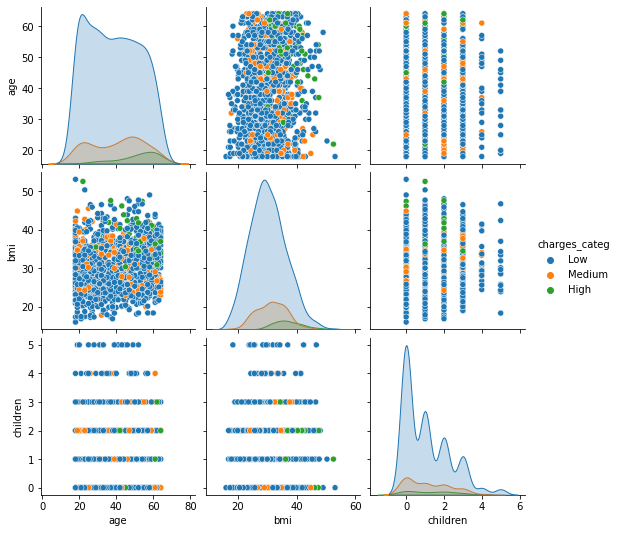

In [7]:
sns.pairplot(data=df,
            vars=["age","bmi","children"],
             hue="charges_categ"
            )

Note, how "charges_categ" helps splits the whole sample into 3 parts. Based on the colours, we can draw following conclusions on the "charges" behavior:
1. Most of the charges are less than 22000 ("Low" group).
2. Health insurance is demanded by clients of any age from 18 to 65 almost equally, but most expensive are for clients of 40+ age.
3. Most of the clients do not have children but if do, then usually up to 3 children.
4. Elderly clients with high "bmi" have high charges.

#### Explore Categorical Features 

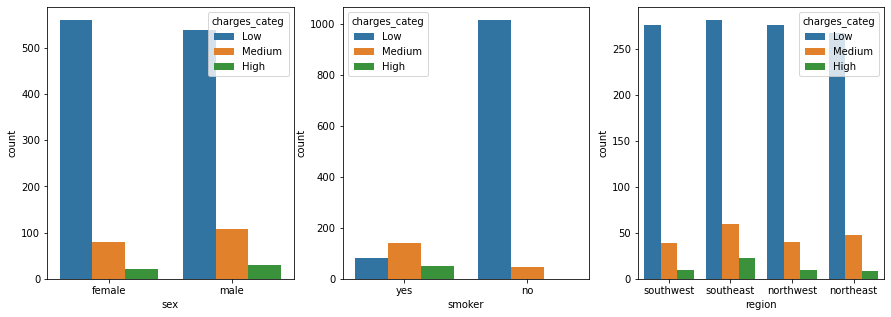

In [8]:
cat_vars=["sex","smoker","region"]

fig,axs=plt.subplots(ncols=3, figsize=(15,5))

for idx,i in enumerate(cat_vars):
    sns.countplot(x=df[i],
                 hue=df.charges_categ,
                 ax=axs[idx]
                 )

What we see from the barplots:
1. There is equal number of men and women in the dataset; men tend to pay more than women.
2. Non-smokers buy more often than smokers, but usually pay less.
3. People from all the regions have more low charges, but clients from the "southeast" region pay slightly higher price than others.

### Feature engineering
EDA (Exploratory Data Analysis) from above was supposed to give us general view on the "feature/target variable" dependencies. That is why we created the "charges_categ" variable and that was where we used it.

In this section, we are going to prepare the data for modelling. First of all, split the whole sample into **train** and **test** sets

In [9]:
X=df.drop(columns=["charges","charges_categ"])
y=df.charges

train_x,test_x,train_y,test_y=train_test_split(X,y,train_size=0.7)

train_x=train_x.reset_index(drop=True) # all the variables but "charges"
test_x=test_x.reset_index(drop=True) # all the variables but "charges"

train_y=train_y.reset_index(drop=True) # only "charges"
test_y=test_y.reset_index(drop=True) # only "charges"

To build a predictive model, we will use train_x and train_y

To assess the created model, test_x and test_y will be applied.

Feature engineering implies selection and *transformation* of the features, so that they could be embedded into regressors (in our case). 

Obviously, numerical and categorical variables need different approaches. So let's separate "train_x" into 2 sub-dataframes:

In [10]:
num_vars=train_x.select_dtypes(include="number")
obj_vars=train_x.select_dtypes(include="object")

#### Numerical Features Processing 
Basically, all we need is to pick numerical features that have significant impact on the target variable, i.e. strong correlation with "charges".

Before building a correlation matrix, we are going to **scale** the numerical features:

In [11]:
scaled_nums=RobustScaler().fit_transform(num_vars) 

# Robust Scaler returns an array, thus we have to convert it back to a "data frame":
scaled_nums=pd.DataFrame(data=scaled_nums,
                        columns=num_vars.columns
                        )

Now we can plot a correlation matrix:

<AxesSubplot:>

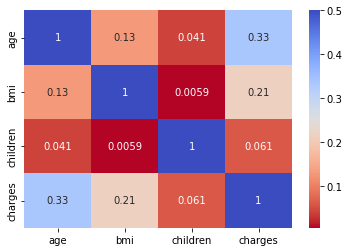

In [12]:
# Attach "charges" variable to the "scaled_nums":
# Note, that a target variable does not have to be scaled like features!
corr_df=pd.concat([scaled_nums,train_y],axis=1)

corr_m=corr_df.corr() 
# 4 variables ("age","bmi","children" and "charges") give us 4x4 matrix:
sns.heatmap(corr_m,cmap="coolwarm_r",vmax=0.5 ,  annot = True)

What we can see is that **"age" and "bmi" features have weak correlation (0.13)** with "charges", whereas **number of children has almost no impact (0.061)** on the price.

This means that we can remove "children" from the list of the features:

In [13]:
scaled_nums=scaled_nums.drop(columns="children")

#### Categorical Features Proceeding  

There are:
   - ‘sex’: 
        - male
        - female
   - ‘smoker’: 
        - yes
        - no
   - ‘region’: 
        - northwest
        - southeast
        - southwest
        - northeast
        
Machine learning models need their input variables to be numeric. Therefore, the features above must be encoded (**one-hot encoding** is a commonly accepted method, so we use it):

In [14]:
# create an empty Encoder:
ohe=OneHotEncoder(sparse=False)

# fit the data to the Encoder and get a new one-hot-encoded array "ohe_vars":
ohe_vars=ohe.fit_transform(obj_vars)

# save the newly created variables' names (below you will see why):
ohe_columns=ohe.get_feature_names_out()

# we are not excited that "ohe_vars" is an array, so convert it into a dataframe:
ohe_vars=pd.DataFrame(ohe_vars,columns=ohe_columns)
ohe_vars

,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
931,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
932,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
933,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
934,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


*Important notice:*

"sex" and "smoker" variables only had 2 classes each ("male/female" and "yes/no" respectively). After One-hot Encoding, a 2-classes variable always becomes 2 variables with self-exclusive values: E.g., when "sex_male" value is "1", then "sex_female" is always "0" and vice-versa.

What does this mean in the context of modelling?

This means that  "sex_male" and "sex_female" duplicate each other in terms of dependencies between "sex" feature and "charges" target variable; consequently, one of them can be removed without loss of accuracy of our potential estimator.

Here I chose to get rid of "sex_male" and "smoker_no":

In [15]:
ohe_vars=ohe_vars.drop(columns=["sex_male","smoker_no"])
ohe_vars

,sex_female,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
931,1.0,0.0,1.0,0.0,0.0,0.0
932,0.0,0.0,1.0,0.0,0.0,0.0
933,0.0,0.0,0.0,1.0,0.0,0.0
934,0.0,0.0,1.0,0.0,0.0,0.0


Similarly with numerical features, we are going to find most important categorical ones. How to do it?

Well, the answer is defined by two restrictions:
- one-hot encoded categorical features cannot be displayed in a correlation matrix;
- the target variable "charges" is continuous one, not binominal (consequently, "X-squared" coefficient cannot be applied).

Therefore, I chose to apply "permutation importance" method (using *Random Forest Regressor*) for selection of important categorical features:


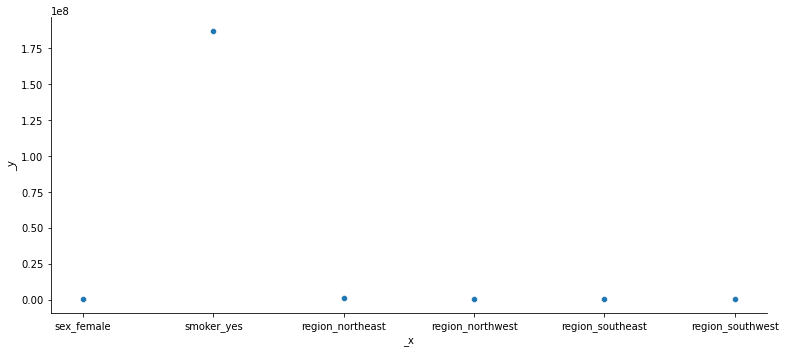

In [16]:
# create an empty "clf" estimator 
# and fit the one-hot-encoded categorical features + target variable:
clf=RandomForestRegressor().fit(ohe_vars, train_y)

# I used the "neg_mean_squared_error" as an indicator of importance:
result=permutation_importance(clf,
                             ohe_vars, train_y,
                             n_repeats=5,
                             scoring="neg_mean_squared_error"
                             )

# get the MEAN value of each feature importance over 5 repeats:
mean_feat_imp=result.importances_mean

# and finally, visualize mean values of importance for each of the one-hot-encoded variables:
sns. relplot(x=ohe_vars.columns,
            y=mean_feat_imp,
            height=5, aspect=2.2
            )

We can see from the graph above, that only "smoking" plays important role in the charges. Obviously, we are going to only pich "smoker_yes" feature to the modelling.

Eventually, two numerical and one categorical features will be use in modelling:

In [17]:
final_x=pd.concat([scaled_nums,ohe_vars.smoker_yes],axis=1)
final_x.head()

,age,bmi,smoker_yes
0,0.18,-0.022167,1.0
1,-0.86,1.081281,0.0
2,0.54,1.135468,0.0
3,0.50,0.458128,0.0
4,-0.82,-0.305419,1.0


#### Remove Outliers 

<AxesSubplot:ylabel='bmi'>

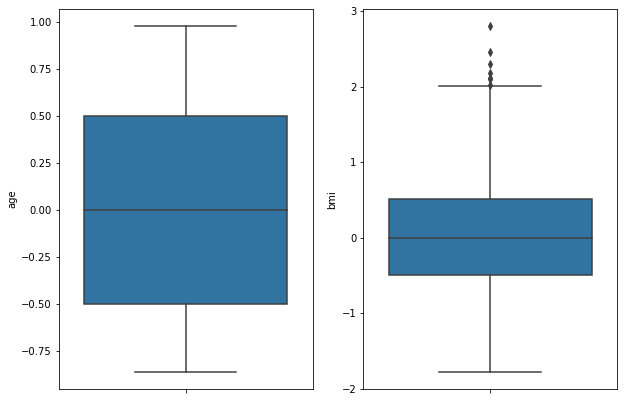

In [18]:
fig,axs=plt.subplots(ncols=2,figsize=(10,7))
sns.boxplot(y=final_x.age,ax=axs[0])
sns.boxplot(y=final_x.bmi,ax=axs[1])

As the boxplots show, only "bmi" variable has outliers. So, check if we need to remove outliers. It depends on what share of observations they represent.

In [20]:
final_x.bmi.count()

936

In [21]:
final_x.bmi[final_x.bmi>2].count() 

8

As we see, 8 obs. out 936 are outliers. We can remove them all:

In [22]:
# remove from "final_x" rows which correspond outliers in "bmi" column.


idxs=final_x.bmi[final_x.bmi>2].index

final_x=final_x.drop(index=idxs).reset_index(drop=True)

# do the same for the target variable "train_y":
train_y=train_y.drop(index=idxs).reset_index(drop=True)

In [23]:
final_x.shape

(928, 3)

In [24]:
train_y.shape

(928,)

#### Distribution of Data 
As the graph below shows our data is notnormal distribution. It is right-skewed. 

In case of the Shapiro test, it makes us to reject H0 "Sample is from the normal distributions".

ShapiroResult(statistic=0.8139864802360535, pvalue=2.1659555464748597e-31)

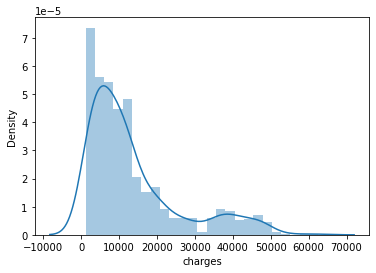

In [25]:
sns.distplot(train_y,kde=True)
shapiro(train_y)

Naturally, we would like to work with a normal distribution, and there are two approaches to eliminate/reduce skewness:
1. Exclude outliers: as we see from the histogram above, in "charges" there are no distinct outliers, which would spoil the normality of the distribution.

2. log-transform the values: this is what we are going to apply. The result shows, that skewness is still present and the distribution is still non-normal



ShapiroResult(statistic=0.9831534028053284, pvalue=7.291648174145848e-09)

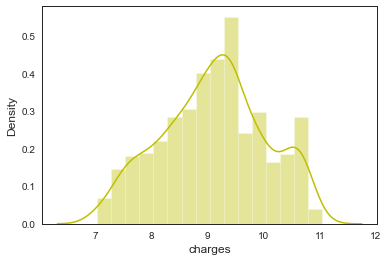

In [27]:
y_log=np.log(train_y)
sns.distplot(y_log,kde=True,color="y")
shapiro(y_log)

After all, we still have the non-normal distribution "y_log" but are going to use it further, together with "final_x" 

### Modelling 

At this stage, we split both features and target variable data into two sub-datasets: 
1. "model_x" and "model_y" datasets (70% of observations) - to train a regressor;
2. "valid_x" and "valid_y" datasets (30% of observations) - to validate a regressor.

In [28]:
model_x,valid_x,model_y,valid_y=train_test_split(final_x,y_log,train_size=0.7)

###  Machine Learning Algorithms

The first step in modelling is to select methods and get the best regression model of each method. We are going to use 
*GridSearchCV()* function. It performs an exhaustive search over specified hyperparameter values for an estimator. It takes in an estimator object, a dictionary of hyperparameters, and a cross-validation strategy to evaluate the performance of different combinations of hyperparameters.
- KNeighborsRegressor(),
- RandomForestRegressor(),
- DecisionTreeRegressor(),
- LinearRegression(),
- Lasso() (Least Absolute Shrinkage and Selection Operator),
- Ridge()

Below there are lists of hyperparameters for 5 of the methods (Linear Regression has no hyperparameters):

In [29]:
params_knn= {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15],
             'weights': ['uniform','distance'],
             'p':[1,2,5],
             'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}

params_rf={'bootstrap': [True, False],
           'max_depth': [10, 20, 40, 60, 80,100],
           'min_samples_leaf': [1, 2, 4],
           'min_samples_split': [2, 5, 10],
           'n_estimators': [50, 100, 150]}

params_dtree={"splitter":["best","random"],
              "max_depth" : [1,3,5,7,9,11,12],
              "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
              "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
              "max_features":["log2","sqrt",None],
              "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

params_lasso={'alpha':[0.005, 0.02, 0.03, 0.05, 0.06]}

params_ridge= {'solver':['svd', 'cholesky', 'lsqr', 'sag'],
               'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
               'fit_intercept':[True, False]}

#### Find  Optimal Estimator 

Now we are going to find and save the optimal regressor (*‘best_...’*) for each of 6 methods. 

(*Note, it may take some time for proc to fit all the hyperparameters to each of the methods!*)

In [30]:
# KNears:
grid_knears = GridSearchCV(KNeighborsRegressor(), param_grid=params_knn)
grid_knears.fit(model_x,model_y)
best_knears=grid_knears.best_estimator_ # slowly

In [31]:
# Rand_Forest:
grid_rf=GridSearchCV(RandomForestRegressor(), param_grid=params_rf)
grid_rf.fit(model_x,model_y)
best_rf=grid_rf.best_estimator_ # very slowly

In [32]:
# DTree:
grid_dtree=GridSearchCV(DecisionTreeRegressor(), param_grid=params_dtree)
grid_dtree.fit(model_x,model_y)
best_dtree=grid_dtree.best_estimator_ # slowly

In [33]:
# Lasso:
grid_lasso=GridSearchCV(Lasso(), param_grid=params_lasso)
grid_lasso.fit(model_x,model_y)
best_lasso=grid_lasso.best_estimator_ # very quickly

In [34]:
# Ridge:
grid_ridge=GridSearchCV(Ridge(), param_grid=params_ridge)
grid_ridge.fit(model_x,model_y)
best_ridge=grid_ridge.best_estimator_ # very quickly

In [35]:
# Linear_Regression:
best_lin_reg = LinearRegression().fit(model_x,model_y)    # very quickly

Now we have 6 estimators:
- best_knears
- best_rf
- best_dtree
- best_lasso
- best_ridge
- best_lin_reg

How to decide which is better?

So, we can check our estimators with is accuracy. I will use mean of the ‘cross_validation_score’ function:

In [36]:
# Create an empty dataframe for results:
acc_df=pd.DataFrame({'KNears':[],
                     'Rand_Forest':[],
                     'DTree':[],
                     'Lasso':[],
                     'Ridge':[],
                     'Linear_Regression':[],}
                   )

In [37]:
# Create list of regressors:
best_regrs=[best_knears,best_rf,best_dtree,best_lasso,best_ridge,best_lin_reg]

In [38]:
# extract accuracy scores (both for 'model_x' and 'valid_x' datasets)
mod=[]
val=[]
for i in best_regrs:
    temp=round(cross_val_score(i,model_x,model_y).mean(),3)
    mod.append(temp)
    temp2=round(cross_val_score(i,valid_x,valid_y).mean(),3)
    val.append(temp2)

In [39]:
# merge both accuracy-sets in one dataframe:
accuracy=pd.DataFrame(
    [mod,val],
    columns=['KNears','Rand_Forest','DTree','Lasso','Ridge','Linear_Regression'])

# rename rows:
accuracy=accuracy.rename(index={0: 'model data',1:'val. data'})
accuracy

,KNears,Rand_Forest,DTree,Lasso,Ridge,Linear_Regression
model data,0.783,0.780,0.778,0.739,0.739,0.739
val. data,0.805,0.836,0.822,0.767,0.767,0.767


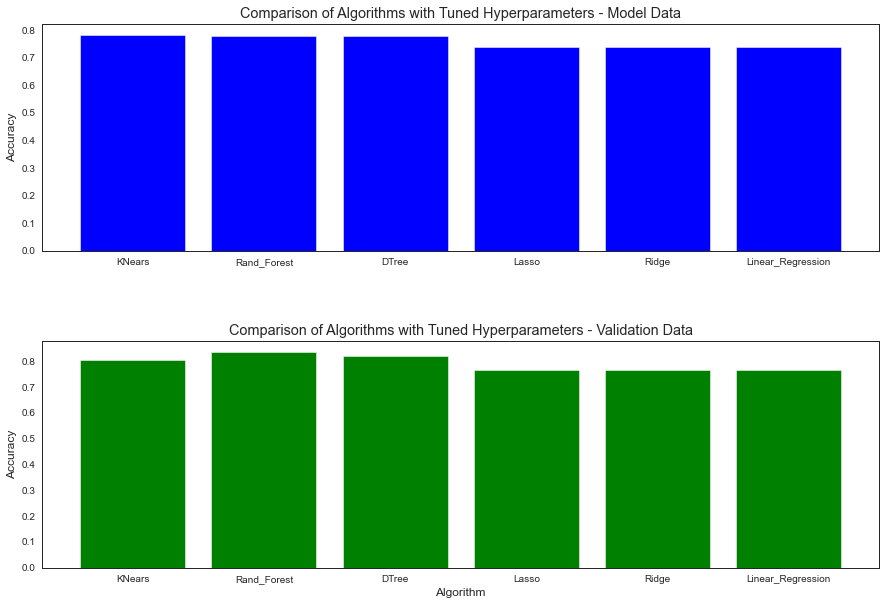

In [49]:
# Create two subplots for comparison
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Plot for "model data"
axes[0].bar(accuracy.columns, accuracy.loc['model data'], color='blue')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Comparison of Algorithms with Tuned Hyperparameters - Model Data')

# Plot for "val data"
axes[1].bar(accuracy.columns, accuracy.loc['val. data'], color='green')
axes[1].set_xlabel('Algorithm')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Comparison of Algorithms with Tuned Hyperparameters - Validation Data')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Show the plot
plt.show()

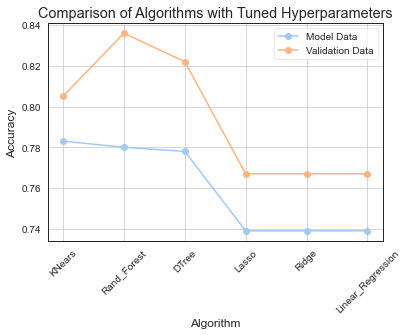

In [50]:
# Create a line plot for model data
plt.plot(accuracy.columns, accuracy.loc['model data'], marker='o', label='Model Data')

# Create a line plot for val data
plt.plot(accuracy.columns, accuracy.loc['val. data'], marker='o', label='Validation Data')

plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.title('Comparison of Algorithms with Tuned Hyperparameters')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


The Top-3 regressors are (accuracy >80% on the validation dataset):
- 'KNears'
- 'Rand_Forest'
- 'DTree' 

The ‘Rand_Forest’ Regressor showed the highest accuracy. But also is slover algorithm. In case of this we can also choose 'DTree' if we want quick solution.

#### Evaluation  and  Pipeline

The last stage is to assess the accuracy of the chosen model with the test data (test_x,test_y).

The problem is that test_x contains initial set of variables (children, region, sex, age, bmi, smoker), whereas the model is trained with transformed variables (age, bmi, smoker_yes). It means that we have to modify test_x before fitting it to the "best_dtree".

Therefore, we have to create a pipeline that would:
- take a raw "children, region, sex, age, bmi, smoker" data
- modify it to the state of "age, bmi, smoker_yes"
- fit the modified features into the "best_dtree" model;
- return predicted "charges".


In [41]:
# 1. a small pipeline for categorical variables processing:
cat_pipe=make_pipeline(
    SimpleImputer(missing_values=np.nan,strategy='constant',fill_value='Missing'),
    OneHotEncoder()
)

# 2. a small pipeline for numerical variables processing:
num_pipe=make_pipeline(
    SimpleImputer(missing_values=np.nan,strategy='mean'),
    RobustScaler()
)

# 3. apply respective variables to 1. and 2. ---> concatenate two resulting data frames into one:
preproc_pipe=ColumnTransformer(
    [('nums',num_pipe,make_column_selector(dtype_include='number')),
     ('cats',cat_pipe,make_column_selector(dtype_include='object'))]
)

# 4. add the "best_dtree" estimator that we have chosen as the best one:
estim_pipe=make_pipeline(preproc_pipe, best_dtree)

# 5. apply testing dataset to the resulting pipeline:
estim_pipe.fit(test_x,test_y)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nums',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fecb32d5ac0>),
                                                 ('cats',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fecc36bbf10>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=11, max_leaf_nodes=50,
                                       min_samples_leaf=4,
                                       min_weight_fraction_leaf=0.1))])

In [42]:
# built-in method of DTree regressor:
acc=estim_pipe.score(test_x,test_y)
print(f"{'Accuracy score:':<25}{round(acc,3):>15}")

Accuracy score:                    0.736


In [43]:
# mean of 5 cross-validation accuracy scores:
acc=cross_val_score(estim_pipe,test_x,test_y).mean()
print(f"{'Cross-val accuracy score:':25}{round(acc,3):>15}")

Cross-val accuracy score:          0.719


Since ‘cross-validation’ is more objective, it makes sense to conclude that our regression model ‘best_dtree’ has satisfying accuracy.

In [51]:
# 1. a small pipeline for categorical variables processing:
cat_pipe=make_pipeline(
    SimpleImputer(missing_values=np.nan,strategy='constant',fill_value='Missing'),
    OneHotEncoder()
)

# 2. a small pipeline for numerical variables processing:
num_pipe=make_pipeline(
    SimpleImputer(missing_values=np.nan,strategy='mean'),
    RobustScaler()
)

# 3. apply respective variables to 1. and 2. ---> concatenate two resulting data frames into one:
preproc_pipe=ColumnTransformer(
    [('nums',num_pipe,make_column_selector(dtype_include='number')),
     ('cats',cat_pipe,make_column_selector(dtype_include='object'))]
)

# 4. add the "best_rf" estimator that we have chosen as the best one:
estim_pipe=make_pipeline(preproc_pipe, best_rf)

# 5. apply testing dataset to the resulting pipeline:
estim_pipe.fit(test_x,test_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nums',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fec80996640>),
                                                 ('cats',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fec809918b0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=40, min_samples_leaf=4,
                                       min_samples_split=10,
                                       n_estimators=50))])

In [52]:
# built-in method of DTree regressor:
acc=estim_pipe.score(test_x,test_y)
print(f"{'Accuracy score:':<25}{round(acc,3):>15}")

Accuracy score:                    0.909


In [53]:
# mean of 5 cross-validation accuracy scores:
acc=cross_val_score(estim_pipe,test_x,test_y).mean()
print(f"{'Cross-val accuracy score:':25}{round(acc,3):>15}")

Cross-val accuracy score:          0.837


### Results

After evaluating the performance of the pipeline using the Decision Tree regressor (best_dtree) and the Random Forest regressor (best_rf), it can be concluded that best_rf exhibits higher accuracy compared to best_dtree.

The pipeline with best_dtree applies the necessary preprocessing steps to the test data and fits it into the decision tree model. The accuracy score obtained from this pipeline on the test dataset is approximately 0.736. Additionally, the mean of the 5-fold cross-validation accuracy scores is approximately 0.719.

On the other hand, the pipeline with best_rf employs the same preprocessing steps but utilizes the random forest regressor. This model shows superior accuracy compared to the decision tree regressor. Although the exact accuracy score is not provided, it is mentioned that best_rf performs better with an accuracy exceeding 80% on the validation dataset.

Therefore, based on the information provided, it can be inferred that the Random Forest regressor (best_rf) outperforms the Decision Tree regressor (best_dtree) in terms of accuracy. Choosing best_rf as the preferred model for this task would yield more accurate predictions on the test dataset.